In [26]:
#IBM Data Science Applied Capstone Project Week 4

# Collecting and Processing Data

In [19]:
import json #to read the json file containing delhi spatial data
import pandas as pd 

import os #for retrieving the API keys

#libraries to geocodem, map and visualize spatial data
from geopy.geocoders import Nominatim
from geopy.geocoders import Bing
from geopy.extra.rate_limiter import RateLimiter 
import folium

import requests #for making api calls

from IPython.display import Image #to visualize the images of maps constructed

from bs4 import BeautifulSoup #to scrape web data

Loading the geojson file containing the spatial data for the wards of Delhi. Delhi is divided into 272 wards.

In [5]:
with open('Delhi_Wards.geojson') as json_data:
    delhi_geojson = json.load(json_data)

You can view the json file here: https://github.com/datameet/Municipal_Spatial_Data/blob/master/Delhi/Delhi_Wards.geojson?short_path=18d52b8 <br>
I have commented the below cell as the file is very big.

In [52]:
#delhi_geojson

Taking a look at the structure of one of the wards.

In [8]:
delhi_temp = delhi_geojson['features']
delhi_temp[0]

{'type': 'Feature',
 'properties': {'Ward_Name': 'DELHI CANTT CHARGE 1', 'Ward_No': 'CANT_1'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[77.13227880200003, 28.63154473900005],
    [77.13643800200003, 28.62062388000004],
    [77.13647393500008, 28.614173338000057],
    [77.13663563100005, 28.613416280000024],
    [77.13729140200007, 28.612572469000042],
    [77.13694105900004, 28.612462064000056],
    [77.13470425400004, 28.613006204000044],
    [77.13274592600004, 28.613676519000023],
    [77.12831723200003, 28.61605018700004],
    [77.12836214800006, 28.616286762000072],
    [77.13124574000005, 28.620600224000043],
    [77.12432871200008, 28.62149916800007],
    [77.12380768900005, 28.621688418000076],
    [77.13227880200003, 28.63154473900005]]]}}

#### Creating a dataframe to contain the ward number and its name.

In [30]:
delhi_neighbourhoods = pd.DataFrame(columns=['Ward Number', 'Neighbourhoods'])

#### Appending the Neighbourhood data into the dataframe

In [31]:
for data in delhi_temp:
    hood = data['properties']['Ward_Name']
    wno = data['properties']['Ward_No']
    delhi_neighbourhoods = delhi_neighbourhoods.append({'Ward Number': wno, 'Neighbourhoods': hood}, ignore_index=True)

In [32]:
delhi_neighbourhoods.tail(10)

,Ward Number,Neighbourhoods
280,113,MAHAVIR NAGAR
281,153,DARYAGANJ
282,93,BALJIT NAGAR
283,32,NILOTHI
284,36,PRATAP VIHAR
285,33,PREM NAGAR
286,73,SHASTRI NAGAR
287,107,VISHNU GARDEN
288,270,TUKHMIR PUR
289,142,RAJ NAGAR


In [33]:
#Creating a dataframe containing the string ', Delhi, India' after the neighbourhood name to accurately geocode the neighbourhood
addresses = delhi_neighbourhoods['Neighbourhoods']+', Delhi, India'
addresses.head()

0    DELHI CANTT CHARGE 1, Delhi, India
1    DELHI CANTT CHARGE 2, Delhi, India
2    DELHI CANTT CHARGE 4, Delhi, India
3    DELHI CANTT CHARGE 5, Delhi, India
4    DELHI CANTT CHARGE 6, Delhi, India
Name: Neighbourhoods, dtype: object

#### Geocoding the Neighbourhoods using the Bing API
I find the Bing API to be more powerful and accurate than Nominatim, hence, have used it instead.

In [53]:
key = os.environ.get('BING_KEY')
#print(key)

In [35]:
locator = Bing(api_key=key, user_agent="delhi_hoods")
geocode = RateLimiter(locator.geocode, min_delay_seconds=0.1)
delhi_neighbourhoods['location'] = addresses.apply(geocode)
delhi_neighbourhoods['point'] = delhi_neighbourhoods['location'].apply(lambda loc: tuple(loc.point) if loc else None)
delhi_neighbourhoods.head(10)

,Ward Number,Neighbourhoods,location,point
0,CANT_1,DELHI CANTT CHARGE 1,"(1, Delhi, Delhi 110010, India, (28.60562, 77....","(28.60562, 77.11822, 0.0)"
1,CANT_2,DELHI CANTT CHARGE 2,"(2, Delhi, Delhi 110010, India, (28.60544, 77....","(28.60544, 77.11829, 0.0)"
2,CANT_4,DELHI CANTT CHARGE 4,"(4, Delhi, Delhi 110010, India, (28.60557, 77....","(28.60557, 77.11866, 0.0)"
3,CANT_5,DELHI CANTT CHARGE 5,"(5, Delhi, Delhi 110010, India, (28.6055, 77.1...","(28.6055, 77.11908, 0.0)"
4,CANT_6,DELHI CANTT CHARGE 6,"(6, Delhi, Delhi 110010, India, (28.60532, 77....","(28.60532, 77.11933, 0.0)"
5,CANT_7,DELHI CANTT CHARGE 7,"(7, Delhi, Delhi 110010, India, (28.60943, 77....","(28.60943, 77.11741, 0.0)"
6,CANT_8,DELHI CANTT CHARGE 8,"(8, Delhi, Delhi 110010, India, (28.60914, 77....","(28.60914, 77.11835, 0.0)"
7,CANT_3,DELHI CANTT CHARGE 3,"(3, Delhi, Delhi 110010, India, (28.6051, 77.1...","(28.6051, 77.11844, 0.0)"
8,NDMC_1,NDMC CHARGE 1,"(Delhi, DL, India, (28.634109497070312, 77.216...","(28.634109497070312, 77.21691131591797, 0.0)"
9,NDMC_2,NDMC CHARGE 2,"(Delhi, DL, India, (28.634109497070312, 77.216...","(28.634109497070312, 77.21691131591797, 0.0)"


Number of neighbourhoods which couldn't be geocoded

In [36]:
delhi_neighbourhoods.location.isnull().sum()

0

#### Creating separate columns for Latitude, Longitude and Altitude

In [37]:
delhi_neighbourhoods[['Latitude', 'Longitude', 'altitude']] = pd.DataFrame(delhi_neighbourhoods['point'].tolist(), index=delhi_neighbourhoods.index)
delhi_neighbourhoods.head()

,Ward Number,Neighbourhoods,location,point,Latitude,Longitude,altitude
0,CANT_1,DELHI CANTT CHARGE 1,"(1, Delhi, Delhi 110010, India, (28.60562, 77....","(28.60562, 77.11822, 0.0)",28.60562,77.11822,0.0
1,CANT_2,DELHI CANTT CHARGE 2,"(2, Delhi, Delhi 110010, India, (28.60544, 77....","(28.60544, 77.11829, 0.0)",28.60544,77.11829,0.0
2,CANT_4,DELHI CANTT CHARGE 4,"(4, Delhi, Delhi 110010, India, (28.60557, 77....","(28.60557, 77.11866, 0.0)",28.60557,77.11866,0.0
3,CANT_5,DELHI CANTT CHARGE 5,"(5, Delhi, Delhi 110010, India, (28.6055, 77.1...","(28.6055, 77.11908, 0.0)",28.60550,77.11908,0.0
4,CANT_6,DELHI CANTT CHARGE 6,"(6, Delhi, Delhi 110010, India, (28.60532, 77....","(28.60532, 77.11933, 0.0)",28.60532,77.11933,0.0


#### Dropping any unnecessary columns

In [38]:
delhi_neighbourhoods.drop(['location', 'point', 'altitude'], axis=1, inplace=True)
delhi_neighbourhoods.head()

,Ward Number,Neighbourhoods,Latitude,Longitude
0,CANT_1,DELHI CANTT CHARGE 1,28.60562,77.11822
1,CANT_2,DELHI CANTT CHARGE 2,28.60544,77.11829
2,CANT_4,DELHI CANTT CHARGE 4,28.60557,77.11866
3,CANT_5,DELHI CANTT CHARGE 5,28.60550,77.11908
4,CANT_6,DELHI CANTT CHARGE 6,28.60532,77.11933


In [40]:
delhi_neighbourhoods.to_csv(r'Neighbourhoods.csv',index=None, header=True)

## Adding Housing Prices for each locality
I have used the following link to add average housing prices per square meter in Delhi:<br>
https://www.bankbazaar.com/home-loan/stamp-duty-and-property-registration-charges-delhi.html <br>
The data entry has been manually done to the csv file created above and is then loaded below.

In [5]:
delhi_data = pd.read_csv('Neighbourhoods.csv')
delhi_data.head()

,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr
0,CANT_1,DELHI CANTT CHARGE 1,28.60562,77.11822,NaN
1,CANT_2,DELHI CANTT CHARGE 2,28.60544,77.11829,NaN
2,CANT_4,DELHI CANTT CHARGE 4,28.60557,77.11866,NaN
3,CANT_5,DELHI CANTT CHARGE 5,28.60550,77.11908,NaN
4,CANT_6,DELHI CANTT CHARGE 6,28.60532,77.11933,NaN


There were a lot of localities for which there was no housing price data available. It was either due to that locality being an industrial zone or it not having and residential land or there being no residential land open to the public such as government owned residential complex. We are going to remove those localities and continue with only those localities for which we have the housing price data.

In [6]:
delhi_select = delhi_data[delhi_data.AvgPricePerSqMtr.isnull() == False].reset_index()
delhi_select.drop(columns=['index'], axis=1, inplace=True)
print(delhi_select.shape)
delhi_select.head()

(71, 5)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr
0,80,CHANDNI CHOWK,28.656240,77.232330,70080.0
1,109,JANAK PURI NORTH,28.634109,77.216911,128000.0
2,117,JANAK PURI WEST,28.634109,77.216911,128000.0
3,118,JANAK PURI SOUTH,28.608090,77.103530,128000.0
4,134,NANGLI SAKRAVATI,28.619900,77.005898,34875.0


## Adding Population data
I will now be scraping the following website and adding ward-wise population data for each of Delhi's wards.
https://indikosh.com/city/708693/delhi <br>
I use beautiful soup and pandas to read and create a dataframe of the required table

In [24]:
res = requests.get("https://indikosh.com/city/708693/delhi")
soup = BeautifulSoup(res.content, 'lxml')
table = soup.find_all('table', {'class': 'table sortable'})
table = table[1]
delhi_population = pd.read_html(str(table))
delhi_population = delhi_population[0]
print(delhi_population.shape)
delhi_population.head()

(289, 2)


,Wards,Population
0,Dmc (u) Ward No 125,110469
1,Dmc (u) Ward No 135,107229
2,Dmc (u) Ward No 23,94843
3,Dmc (u) Ward No 206,86392
4,Dmc (u) Ward No 147,83031


#### Stripping the Wards column to be able to merge using the Ward Number column in the delhi_select dataframe

In [25]:
delhi_population['Wards'] = delhi_population['Wards'].str.strip(r"Dmc (u) Ward No ")
#delhi_population.Wards = delhi_population.Wards.astype('int64')
delhi_population.rename(columns={'Wards':'Ward Number'}, inplace=True)
delhi_population.head()

,Ward Number,Population
0,125,110469
1,135,107229
2,23,94843
3,206,86392
4,147,83031


Checking dypes of **Ward Number** before merging

In [26]:
print(delhi_select.dtypes)
print(delhi_population.dtypes)

Ward Number          object
Neighbourhoods       object
Latitude            float64
Longitude           float64
AvgPricePerSqMtr    float64
dtype: object
Ward Number    object
Population      int64
dtype: object


#### Merging the two dataframes 

In [27]:
delhi_data = pd.merge(delhi_select, delhi_population, how='left', on='Ward Number')
print(delhi_data.shape)
delhi_data.head()

(99, 6)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population
0,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,36296.0
1,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,1978.0
2,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,36168.0
3,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,11038.0
4,117,JANAK PURI WEST,28.634109,77.216911,128000.0,29997.0


#### Couting the missing value rows

In [29]:
delhi_data.Population.isnull().sum()

7

#### Dropping rows with missing values

In [32]:
delhi_data.dropna(subset=['Population'], axis=0, inplace=True)
delhi_data.Population.isnull().sum()

0

In [34]:
print(delhi_data.shape)
delhi_data.head()

(92, 6)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population
0,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,36296.0
1,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,1978.0
2,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,36168.0
3,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,11038.0
4,117,JANAK PURI WEST,28.634109,77.216911,128000.0,29997.0


In [35]:
delhi_data.to_csv(r'DelhiHoodData.csv',index=None, header=True)

## Collecting Venues for each locality 
Now that we have all the localities for which we want to do the analysis on, all that's left is the venue data. We will now collect venues for each locality using the foursquare api. 

In [37]:
delhi_data = pd.read_csv('DelhiHoodData.csv')
print(delhi_data.shape)
delhi_data.head()

(92, 6)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population
0,80,CHANDNI CHOWK,28.65624,77.232330,70080.0,36296.0
1,80,CHANDNI CHOWK,28.65624,77.232330,70080.0,1978.0
2,109,JANAK PURI NORTH,28.63411,77.216911,128000.0,36168.0
3,109,JANAK PURI NORTH,28.63411,77.216911,128000.0,11038.0
4,117,JANAK PURI WEST,28.63411,77.216911,128000.0,29997.0


We will first quickly visualize Delhi and the neighbourhoods on which we'll be doing our analysis. For this I'll be plotting a map of Delhi and superimposing the neighbourhoods on top of it. To do that, let's first get the geographical coordinates of Delhi.

In [38]:
address = 'Delhi, India'

geolocator = Nominatim(user_agent='Delhi')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Delhi are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Delhi are 28.6517178, 77.2219388.


#### Using folium to map Delhi and superimpose the Neighbourhoods from delhi_Data

In [39]:
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, hood in zip(delhi_data['Latitude'], delhi_data['Longitude'], delhi_data['Neighbourhoods']):
    label = '{}'.format(hood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_delhi)  
    
map_delhi

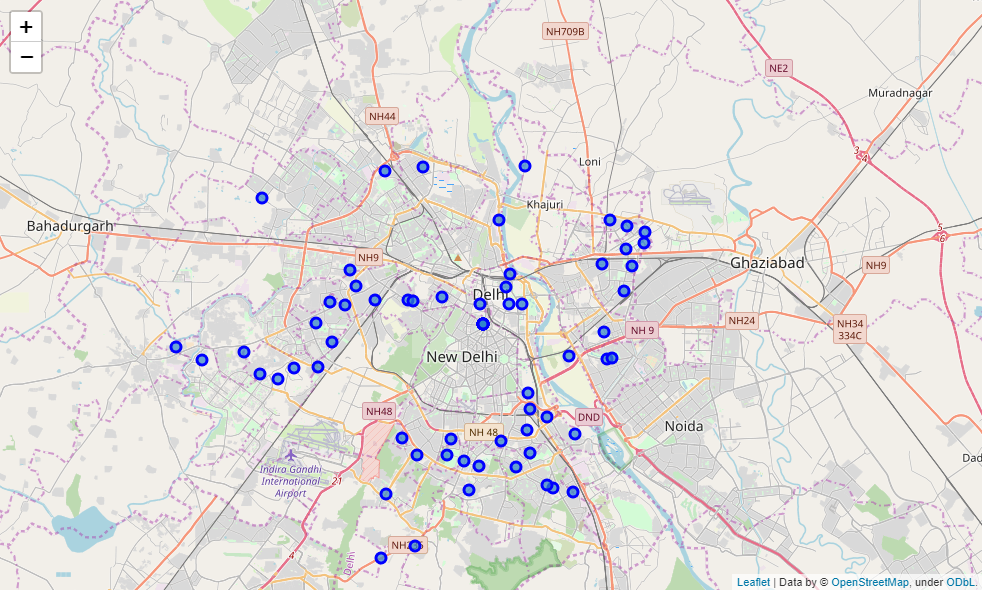

In [40]:
PATH = "D:/IBM Data Science/Coursera_Capstone/Delhi Analysis/"
Image(filename = PATH + "Delhi and Neighbourhoods.png")

**Retrieving the FourSquare API Credentials**<br>
I have added the API ID and Key to the <i>environment variables</i> on Windows and I use the <i>os</i> library to import the credentials. This keeps it secure while sharing the notebook on github or with someone else.

In [41]:
CLIENT_ID = os.environ.get('FS_ID') 
CLIENT_SECRET = os.environ.get('FS_SECRET') 
VERSION = '20180604'

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' 

#### Defining the function to obtain top venues from each Neighbourhood

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running the function and creating a new dataframe called <i> delhi_venues </i>.

In [43]:
delhi_venues = getNearbyVenues(names=delhi_data['Neighbourhoods'],
                               latitudes=delhi_data['Latitude'],
                               longitudes=delhi_data['Longitude'])

CHANDNI CHOWK
CHANDNI CHOWK
JANAK PURI NORTH
JANAK PURI NORTH
JANAK PURI WEST
JANAK PURI WEST
JANAK PURI SOUTH
JANAK PURI SOUTH
KAKRAULA
DILSHAD GARDEN
NEW SEEMA PURI
NAND NAGRI
SUNDER NAGARI
ASHOK NAGAR
NIZAMUDDIN
NIZAMUDDIN
NIZAMUDDIN
BHOGAL
KASTURBA NAGAR
MALVIYA NAGAR
ANDREWSGANJ
ANDREWSGANJ
VASANT VIHAR
MUNIRKA
NANAK PURA
VASANTKUNJ
DAKSHINPURI EXT.
SHAPUR JAT
GREATER KAILASH-I
GREATER KAILASH-I
GREATER KAILASH-I
EAST OF KAILASH
EAST OF KAILASH
GOVIND PURI
KALKAJI
OKHLA
PAHAR GANJ
VIVEK VIHAR
VIVEK VIHAR
DILSHAD COLONY
PUNJABI BAGH
KIRTI NAGAR
KIRTI NAGAR
KASHMERE GATE
KASHMERE GATE
KASHMERE GATE
MAJNU KA TILA
MAJNU KA TILA
JAMA MASJID
JAMA MASJID
UTTAM NAGAR
UTTAM NAGAR
DABRI
MAYUR VIHAR PHASE-I
ROHINI
ROHINI
PASCHIM VIHAR NORTH
PASCHIM VIHAR SOUTH
ROHINI EAST
ROHINI CENTRAL
ROHINI SOUTH
I.P EXTENTION
ANAND VIHAR
MAYUR VIHAR PHASE II
MAHAVIR ENCLAVE
EAST PATEL NAGAR
EAST PATEL NAGAR
WEST PATEL NAGAR
KAROL BAGH
KAROL BAGH
KAROL BAGH
JAHANGIRPURI-I
RAJOURI GARDEN
HARI NAGAR
HARI NA

Let's have a look at the delhi_venues dataframe and its shape

In [44]:
print(delhi_venues.shape)
delhi_venues.head(7)

(1149, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CHANDNI CHOWK,28.65624,77.23233,Haveli Dharampura,28.653247,77.232309,Hotel
1,CHANDNI CHOWK,28.65624,77.23233,Jalebi Wala | जलेबी वाला,28.656178,77.233526,Dessert Shop
2,CHANDNI CHOWK,28.65624,77.23233,Chandni Chowk | चाँदनी चौक (Chandni Chowk),28.656076,77.230740,Market
3,CHANDNI CHOWK,28.65624,77.23233,Babu Ram Paranthe Wale,28.655820,77.230448,Indian Restaurant
4,CHANDNI CHOWK,28.65624,77.23233,Haldiram's,28.656289,77.231705,Snack Place
5,CHANDNI CHOWK,28.65624,77.23233,Parathe Wali Gali | पराँठे वाली गली,28.656100,77.230479,Market
6,CHANDNI CHOWK,28.65624,77.23233,Parawthe Wale,28.656033,77.230500,Indian Restaurant
